In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# "Теоретическая" функция зависимости объёма продаж от цены

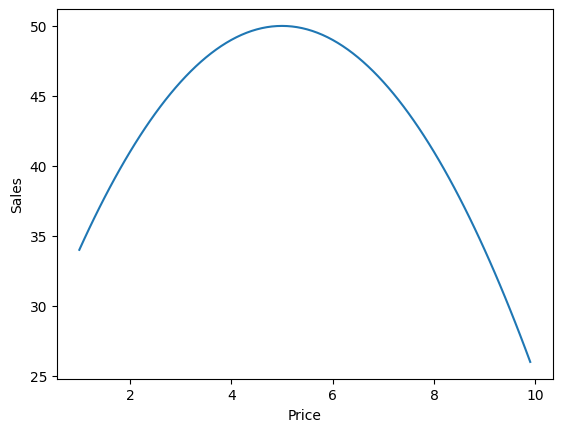

In [2]:
prices = np.arange(1, 10, 0.1)
sales = -(prices - 5)**2 + 50

plt.xlabel('Price')
plt.ylabel('Sales')
plt.plot(prices, sales)

# Создаем "исторический" датасет со случайной ошибкой

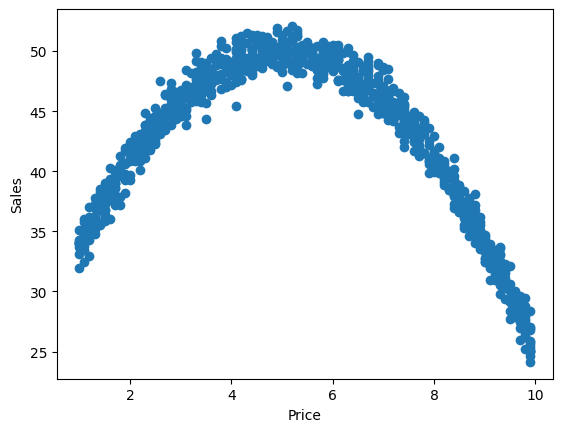

In [3]:
np.random.seed(seed=12345)
x = np.random.choice(list(prices), 1000, replace=True)
y = -(x - 5)**2 + 50 + np.random.normal(loc=0.0, scale=1.0, size=1000)

plt.xlabel('Price')
plt.ylabel('Sales')
plt.scatter(x, y)

# Строим прогнозную нейронную сеть. Минимизируем ошибку прогноза

In [4]:
class NNet(torch.nn.Module):
	def __init__(self):
		super(NNet, self).__init__()
		# коэффициенты при 1-ой и 2-ой степени полинома
		self.poly_coeff = torch.nn.Linear(in_features = 2, out_features = 1, bias = True)
	def forward(self, x):
		powers = torch.stack([x, x**2], dim = 1)
		poly = self.poly_coeff(powers)
		return poly

Оптимизируем по весам - параметрам нейронной сети

In [5]:
nnet = NNet()
opt = torch.optim.Adam(nnet.parameters())
loss_func = torch.nn.MSELoss()

In [6]:
loss_list = []
batch_size = 10
num_epochs = 300
for epoch in range(num_epochs):
	for i in range(len(x)//batch_size):
		# батч входных переменных
		layer_x = torch.tensor([x[i] for i in range(i, i + batch_size)], dtype=torch.float32)
		# батч таргета
		layer_y = torch.tensor([y[i] for i in range(i, i + batch_size)], dtype=torch.float32)
		# предсказания
		pred = nnet(layer_x).squeeze()
		# функция потерь
		loss = loss_func(layer_y, pred)
		# обучаем
		# print(loss.data.item())
		# loss_list.append(loss.data.item())
		opt.zero_grad()
		loss.backward()
		opt.step()
	loss_list.append(loss.data.item())

Text(0, 0.5, 'loss')

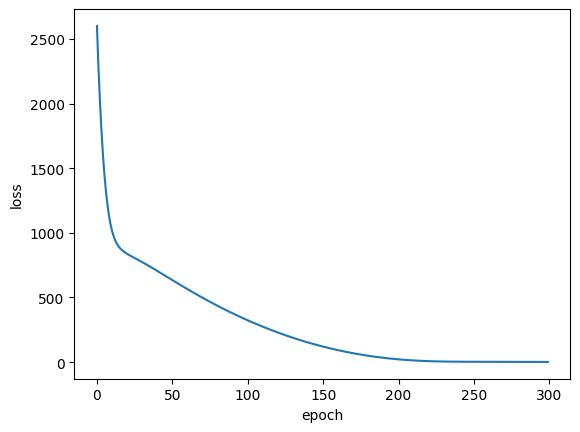

In [7]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')

# График прогнозов

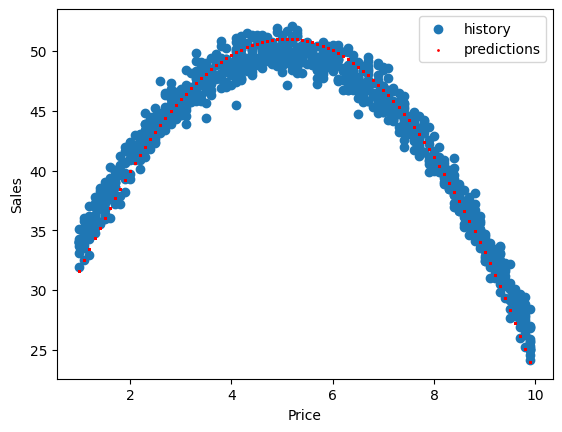

In [8]:
# вектор прогнозов  
layer_x = torch.tensor([x[i] for i in range(len(x))], dtype=torch.float32)
pred = nnet(layer_x).squeeze()

plt.xlabel('Price')
plt.ylabel('Sales')
plt.scatter(x, y, label='history')
plt.scatter(x, pred.detach().numpy(), color="red", s=1, label='predictions')

plt.legend()


# Максимизируем продажи (по цене)

In [9]:
# переводим модель в режим скоринга (для корректной работы с dropout-слоями, если такие есть)
nnet.eval()
# фиксируем веса нейросети
for par in nnet.parameters():
	par.requires_grad = False

Добавим ограничения на цену

In [10]:
def cons(x):
	# ограничение x <= 4.5
	cons_1 = torch.max(torch.cat((torch.tensor([0.]), x - 4.5))) ** 2
	# ограничение x >= 4
	cons_2 = torch.max(torch.cat((torch.tensor([0.]), - x + 4))) ** 2
	
	return torch.sum(torch.stack((cons_1, cons_2)))

# Оптимизация. Простой пример

In [11]:
def plot_result(optimal_price):
    print(f"Оптимиальная цена: {optimal_price}")

    plt.xlabel('Price')
    plt.ylabel('Sales')
    plt.plot(prices, sales, label='Theoretical function')
    plt.axvline(x=optimal_price, color="black", label="Optimal price")
    plt.legend()
    
def plot_goal(goal_list):
    plt.plot(goal_list)
    plt.xlabel('iteration')
    plt.ylabel('goal')

In [12]:
# цены - меняем
layer_x = torch.tensor([1.], requires_grad=True)
# Оптимизируем по цене!!!
opt = torch.optim.Adam([layer_x])

In [13]:
goal_list = []
penalty = 1e3
for i in range(20000):
	opt.zero_grad()
	# goal = - сумма продаж + штрафной коэф. * нарушение ограничений
	goal = -(nnet(layer_x).squeeze()) + penalty * cons(layer_x) 
		
	# print(f"Штрафная функция цели: {goal.data.item()}")
	goal_list.append(goal.data.item())
	goal.backward() 
	opt.step() 

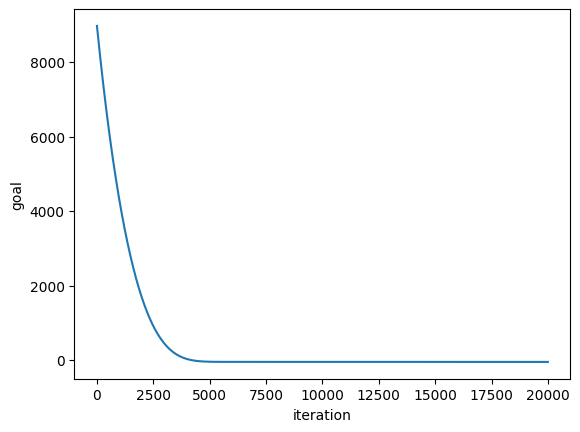

In [14]:
plot_goal(goal_list)

Оптимиальная цена: 4.5


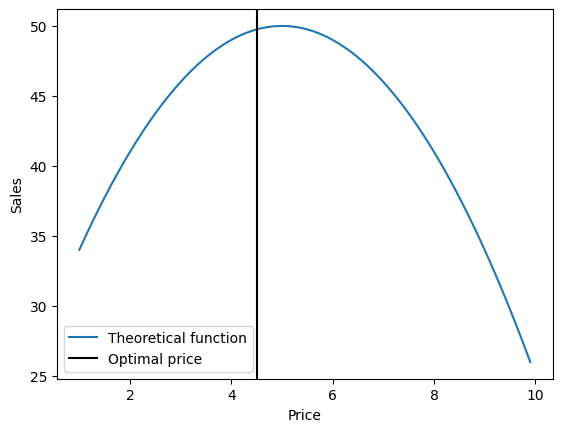

In [15]:
optimal_price = round(layer_x.detach().numpy()[0], 2)
plot_result(optimal_price)

In [16]:
optimal_price_index = np.where(np.round(prices, 2) == optimal_price)[0][0]
print(f"Оптимальное значение продаж: {sales[optimal_price_index]}")

Оптимальное значение продаж: 49.75


# Оптимизация. Метод штрафных функций

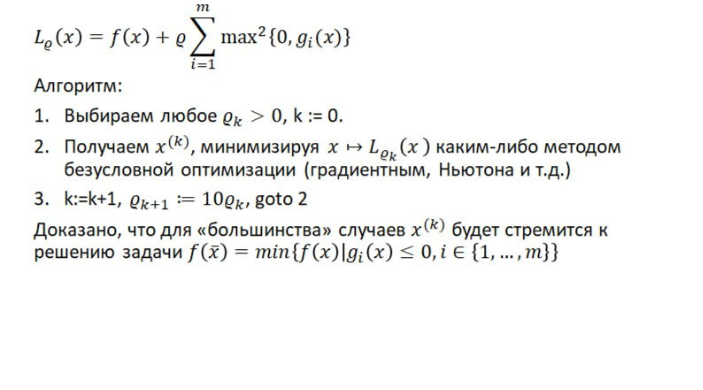

In [18]:
def optimize():
    # цены - меняем
    layer_x = torch.tensor([1.], requires_grad=True)
    # Оптимизируем по цене!!!
    opt = torch.optim.Adam([layer_x])

    goal_list = [] # список для значений штрафной ф-ии
    epsilon=0.0 # порог для изменения штрафной ф-ии 
    gradient_threshold = 1e-4 # порог для градиента штрафной ф-ии по входному вектору
    int_iter_without_growth = 0 # счетчик на кол-во итераций без изменения штрафной ф-ии 
    int_iter_without_growth_threshold = 10 # порог на кол-во итераций без изменения штрафной ф-ии 

    penalty = 100 # коэффициент штрафа
    goals = []
    ex_iterations = 5 # кол-во внешних итераций
    int_iterations=20000 # кол-во внутренних итераций

    for ex_iter in range(ex_iterations):
        for int_iter in range(int_iterations):
            opt.zero_grad()
            goal = -(nnet(layer_x).squeeze()) + penalty * cons(layer_x) 
            goals.append(-goal.data.item())
            goal.backward()
            opt.step()
            goal_list.append(goal.data.item())

            # 1 критерий останова: штрафная ф-я не уменьшается n итераций подряд 
            if int_iter > 0:
                if abs((goals[int_iter] - goals[int_iter - 1]) / goals[int_iter - 1]) <= epsilon:
                    int_iter_without_growth += 1
                    if int_iter_without_growth == int_iter_without_growth_threshold: 
                        print("Internal loop finished 1")
                        break
                else:
                        int_iter_without_growth = 0
                
            # 2 критерий останова: градиент goal по layer_x меньше порогового значения
            gradient = torch.abs(layer_x.grad).item() if (int_iter != 0) else 1e10
            if gradient < gradient_threshold:
                    print("Internal loop finished 2")
                    break 
            
        # увеличиваем штраф
        penalty *= 10

        # критерий останова внешнего цикла: все ограничения выполняются
        if cons(layer_x) == 0.0:
                print("External loop finished 3")
                break
    
    return goal_list, layer_x.detach().numpy()[0]

In [19]:
goal_list, optimal_price = optimize()

Internal loop finished 2
Internal loop finished 1
Internal loop finished 1
Internal loop finished 1
External loop finished 3


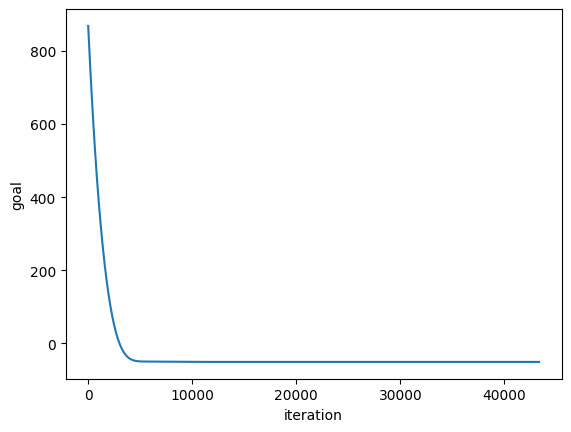

In [20]:
plot_goal(goal_list)

Оптимиальная цена: 4.4997358322143555


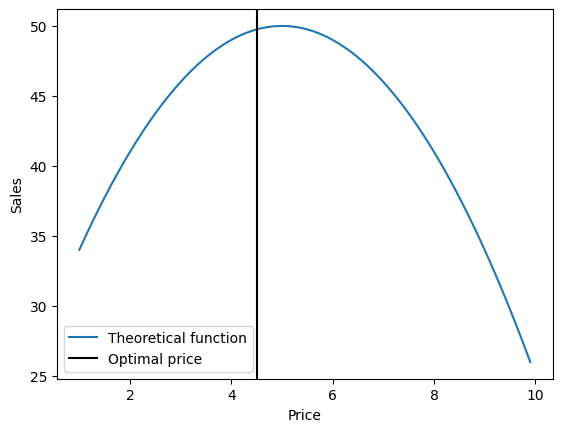

In [21]:
plot_result(optimal_price)

# Оптимизация. Метод точной штрафной функции

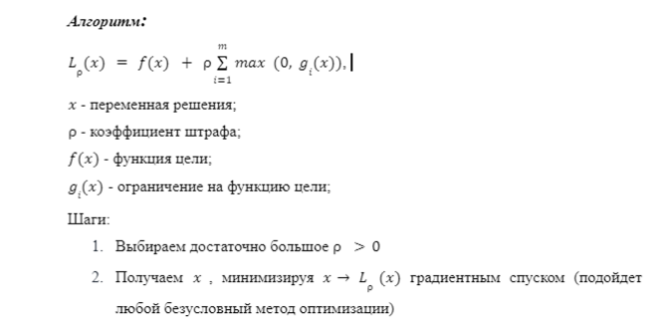

- Убираем возведение в квадрат  ф-ий max0
- На практике мы сглаживаем недифференцируемую функцию x -> max(0, x) дифференцируемой аппроксимацией softplus

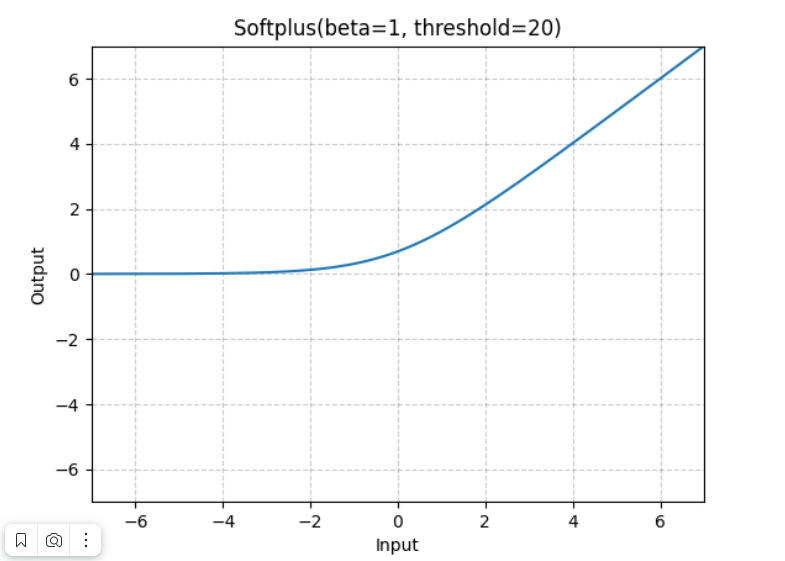

In [22]:
def cons_exact(x):
	# ограничение x <= 4.5
	cons_1 = torch.nn.functional.softplus(x - 4.5, beta=1e3, threshold=1e-1)
	# ограничение x >= 4
	cons_2 = torch.nn.functional.softplus(- x + 4, beta=1e3, threshold=1e-1)
	
	return torch.sum(torch.stack((cons_1, cons_2)))

In [23]:
def optimize():
    # цены - меняем
    layer_x = torch.tensor([1.], requires_grad=True)
    # Оптимизируем по цене!!!
    opt = torch.optim.Adam([layer_x])

    goal_list = [] # список для значений штрафной ф-ии
    epsilon=0.0
    gradient_threshold = 1e-4
    int_iter_without_growth = 0
    int_iter_without_growth_threshold = 10

    penalty = 10000 # устанавливаем большой штраф
    goals = []
    int_iterations=20000
    
    # убираем внешний цикл
    for int_iter in range(int_iterations):
        opt.zero_grad()
        goal = -(nnet(layer_x).squeeze()) + penalty * cons_exact(layer_x) 
        goals.append(-goal.data.item())
        goal.backward()
        opt.step()
        goal_list.append(goal.data.item())

        # 1 критерий останова: штрафная ф-я не уменьшается n эпох подряд и выполнены ограничения
        if int_iter > 0:
            if abs((goals[int_iter] - goals[int_iter - 1]) / goals[int_iter - 1]) <= epsilon and cons_exact(layer_x) <= 0.0:
                int_iter_without_growth += 1
                if int_iter_without_growth == int_iter_without_growth_threshold: 
                    print("Optimization finished 1")
                    break
            else:
                    int_iter_without_growth = 0
            
        # 2 критерий останова: градиент goal по layer_x меньше порогового значения и выполнены ограничения
        gradient = torch.abs(layer_x.grad).item() if (int_iter != 0) else 1e10
        if gradient < gradient_threshold and cons_exact(layer_x) <= 0.0:
                print("Optimization finished 2")
                break 
            
    return goal_list, layer_x.detach().numpy()[0]

In [24]:
goal_list, optimal_price = optimize()

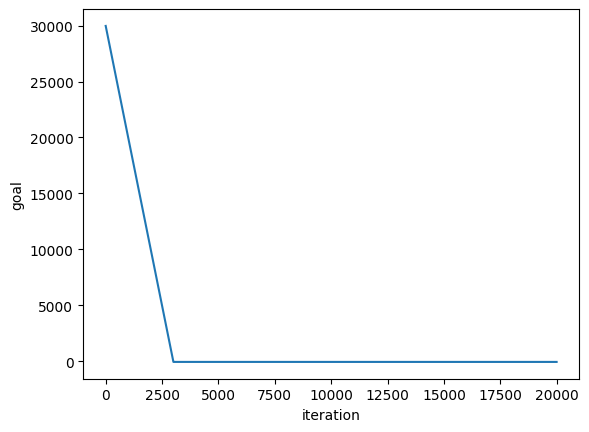

In [25]:
plot_goal(goal_list)

Оптимиальная цена: 4.491113662719727


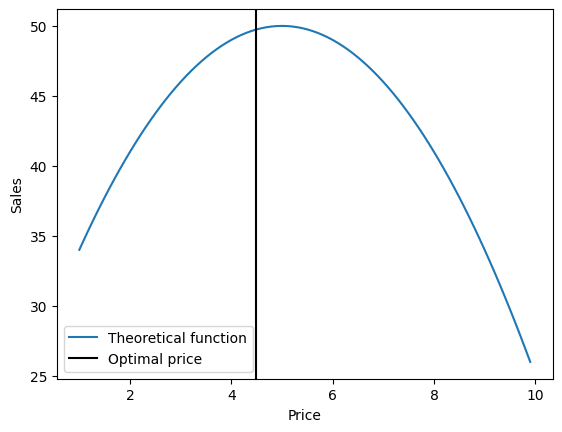

In [26]:
plot_result(optimal_price)

# Оптимизация. Метод модифицированной функции Лагранжа

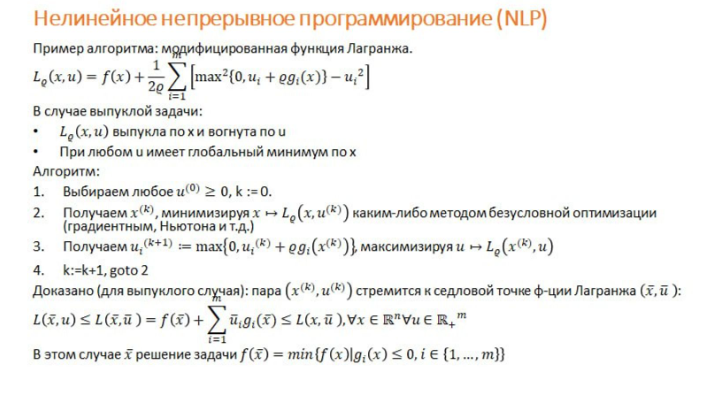

In [27]:
# истинная функция цели
def obj(x):
	return -(nnet(x).squeeze()) 

# ограничения в виде неравенств
def ineq_cons_fun(x):
	cons_1 = x - 4.5
	cons_2 = -x + 4
	return torch.cat((cons_1, cons_2))

# max0
def max0(x, if_diff=True):
	if if_diff:
		res = torch.nn.functional.softplus(x, beta=1e3, threshold=1e-1)
	else:
		res = torch.relu(x)
	return res

penalty = 100 # штраф задаем 100 или 1000 и больше не меняем
def goal_func(x, u):
	return obj(x) + \
		(1/(2*penalty)) * \
		(
			torch.sum(max0(penalty * ineq_cons_fun(x) + u, if_diff=True)**2)
		)

# обновление множителей Лагранжа
def renew_lagrange(u, x):
	u = max0(u + penalty * ineq_cons_fun(x), if_diff=False).clone().detach()
	return u

In [28]:
def optimize():
    # цены - меняем
    layer_x = torch.tensor([1.], requires_grad=True)
    # Оптимизируем по цене!!!
    opt = torch.optim.Adam([layer_x])

    # задаем начальные множители Лагранжа
    m = 2 # число ограничений-неравенств
    u = torch.tensor([0.]*m)

    goal_list = []
    epsilon=0.0
    gradient_threshold = 1e-4
    int_iter_without_growth = 0
    int_iter_without_growth_threshold = 10

    goals = []
    ex_iterations = 10
    int_iterations=20000

    for ex_iter in range(ex_iterations):
        for int_iter in range(int_iterations):
            opt.zero_grad()
            goal = goal_func(layer_x, u)
            goals.append(-goal.data.item())
            goal.backward()
            opt.step()
            goal_list.append(goal.data.item())

            # 1 критерий останова: штрафная ф-я не уменьшается n эпох подряд 
            if int_iter > 0:
                if abs((goals[int_iter] - goals[int_iter - 1]) / goals[int_iter - 1]) <= epsilon:
                    int_iter_without_growth += 1
                    if int_iter_without_growth == int_iter_without_growth_threshold: 
                        print("Internal loop finished 1")
                        break
                else:
                        int_iter_without_growth = 0
                
            # 2 критерий останова: градиент goal по layer_x меньше порогового значения
            gradient = torch.abs(layer_x.grad).item() if (int_iter != 0) else 1e10
            if gradient < gradient_threshold:
                    print("Internal loop finished 2")
                    break 
            
        # обновляем множители Лагранжа 
        u = renew_lagrange(u, layer_x)

        # критерий останова внешнего цикла: все ограничения выполняются и выполняется условие нежесткости
        if all(ineq_cons_fun(layer_x)) == 0.0 and torch.max(torch.abs(u * ineq_cons_fun(layer_x))).item() <= epsilon:
                print("External loop finished 3")
                break
                
    return goal_list, layer_x.detach().numpy()[0]

In [29]:
goal_list, optimal_price = optimize()

Internal loop finished 1
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2
Internal loop finished 2


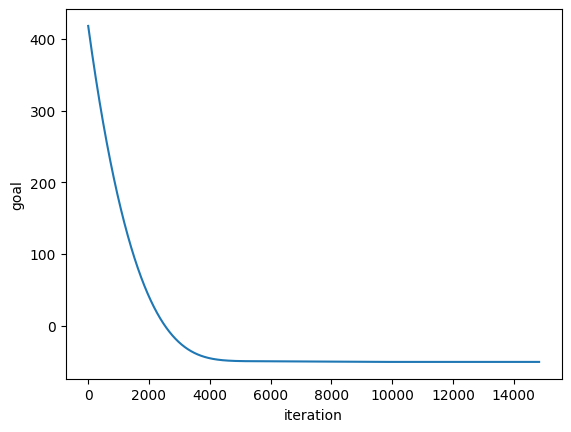

In [30]:
plot_goal(goal_list)

Оптимиальная цена: 4.499999046325684


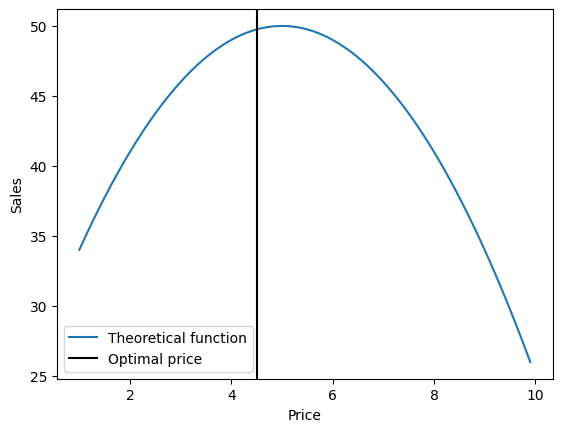

In [31]:
plot_result(optimal_price)

# Пример реализации функции optimize() на кейсе компании "Магнит"

На реальной задаче мы использовали некоторые приемы, которые позволили применить данный метод на большом кол-ве данных:

- прибавление вектора с положительными значениями к вектору нарушений ограничений с целью гарантированно загнать точку решения в допустимую область

In [ ]:
def max0(self, tensor, if_diff=False, plus_eta=False):
    if if_diff:
        res = torch.nn.functional.softplus(tensor, beta=1e3, threshold=1e-1)
    elif plus_eta:
        eta = torch.ones_like(tensor)
        eta[1] = 0.02
        eta[2] = 0.01
        res = torch.relu(tensor + eta)
    else:
        res = torch.relu(tensor)
    return res

- Eсли есть большое кол-во ограничений границ, например значения цен, их можно убрать из функции ограничений и просто "обрезать" сверху и снизу методом torch.clamp

Пример: Если оптимизатор выдал цену x = 50, а допустимая цена от 120 до 150, то torch.clamp вернет x = 120

In [ ]:
with torch.no_grad():
    x_opt[:] = torch.clamp(x_opt, min=lower_bounds, max=upper_bounds)

- Если ограничения - это величины разных масштабов и приоритетов, можно использовать вектор penalty вместо скаляра

Пример: ограничение на цену и ограничение на оборот в процентах

In [ ]:
penalty = base * torch.tensor([1, 1000, 1000], dtype=torch.float32)

Также мы:
- регулировали learning rate
- следили за тем, что штрафная функция цели не "ухудшается" (возрастает)
- ставили хуки на отбор лучших решений в рамках допущений на ограничения 

In [ ]:
# пример реализации функции оптимизации на практике
def optimize(pdf):
    o = Optimizer()
    gr = Group23(pdf)
    n = gr.size
    base = 10
    
    lower_bounds, upper_bounds = gr.get_bounds_for_constraints()
    lower_bounds = torch.tensor(lower_bounds, dtype=torch.float32).squeeze()
    upper_bounds = torch.tensor(upper_bounds, dtype=torch.float32).squeeze()
    
    epsilon_for_constr = torch.tensor([10, 0.001, 0.001], dtype=torch.float32)
    epsilon = 0.01
    
    max_int_epochs = 5
    int_epoch_threshold = 5
    goal_worsening_threshold = 1    
    
    max_ex_epochs = 4
    
    total_epochs = 0    
    
    ex_best_obj = []
    ex_best_x_opt = []
    ex_best_epoch = []
    ex_best_cons = []
    
    x_opt = torch.tensor(gr.get_start_values(), dtype=torch.float32, requires_grad=True)
    
    for ex_epoch in range(max_ex_epochs):
        lr = 5
        opt = torch.optim.Adam([x_opt], lr=lr)
        penalty = base * torch.tensor([1, 1000, 1000], dtype=torch.float32)
        int_goal = []
        int_grad = []
        best_int_obj = 0
        best_int_x_opt = 0
        int_epochs = 0 
        epochs_without_growth = 0
        epochs_with_goal_worsening = 0        
        
        if ex_epoch == max_ex_epochs - 1:
            max_int_epochs = 50
        for int_epoch in range(max_int_epochs):
            
            int_epochs += 1 
            total_epochs += 1
            val = o.goal(gr, x_opt, penalty)
            cons = o.constraints(gr, x_opt)
            obj = o.obj(gr, x_opt)            
            L_max_int = torch.max(torch.abs(x_opt.grad)).item() if (int_epoch != 0) else 0.0
            
            if (best_int_obj > obj) and all(cons <= epsilon_for_constr):
                best_int_x_opt = x_opt.detach().data
                best_int_obj = obj.detach().data.item()
                ex_best_obj.append(best_int_obj)
                ex_best_x_opt.append(best_int_x_opt)
                ex_best_epoch.append(int_epoch)
                ex_best_cons.append(cons)
                
            int_goal.append(val.data.item())
            int_grad.append(L_max_int)
            
            opt.zero_grad()
            val.backward()
            opt.step()
            
            with torch.no_grad():
                x_opt[:] = torch.clamp(x_opt, min=lower_bounds, max=upper_bounds)
            
            val = o.goal(gr, x_opt, penalty)
            obj = o.obj(gr, x_opt)
            L_max_int = torch.max(torch.abs(x_opt.grad)).item()
            
                
            if abs((val.data.item() - int_goal[-1]) / (int_goal[-1])) < epsilon: 
                epochs_without_growth += 1
            else:
                epochs_without_growth = 0
                
            if (val.data.item() > int_goal[-1]):
                epochs_with_goal_worsening += 1
            else:
                epochs_with_goal_worsening = 0                

            if (epochs_without_growth >= int_epoch_threshold):
                print('_______internal_loop_finished_______')                
                break
                
            if (epochs_with_goal_worsening == goal_worsening_threshold): 
                if lr < 0.1:
                    lr -= lr * 0.1 
                else:
                    lr -= lr * 0.3   
                    
                opt = torch.optim.Adam([x_opt], lr=lr)
                epochs_with_goal_worsening = 0
             
        base *= 10
    if len(ex_best_obj) > 0:
        best_prices = gr.get_prices(ex_best_x_opt[np.array(ex_best_obj).argmin()]) 
    else:
        print('Best solution was not found')
        best_prices = gr.get_prices(x_opt.data) 

    return best_prices

# Какие сложности встретились во время работы? Как мы их решали?

Наш синтетический пример:

1. У нас есть цена x
2. Подаем ее в нейронную сеть
3. Получаем прогноз продаж y (функция от цены)
4. Берем от нее производную по x и понимаем, в какую сторону двигать цену, чтобы максимизировать продажи

Как на самом деле:

1. У нас есть цена x и еще много признаков, которые собираются в виде pd.DataFrame и пересчитываются динамически в зависимости от этой цены x (заранее предпосчитать нельзя)
2. Подать эту структуру в нейронную сеть нельзя, так как тогда не получится посчитать производную штрафной ф-ии цели по цене x
3. Переписываем все операции над таблицей (сортировки, группировки, скользящие средние и т.д.) на PyTorch таким образом, чтобы все эти действия можно было выполнять с тензором, который далее подаем на вход нейронной сети
4. Получаем прогноз целевой ф-ии y (функция от цены)
5. Берем от нее производную по x и понимаем, в какую сторону двигать цену, чтобы максимизировать целевую ф-ю

Основная идея здесь в том, что на входе в сеть должен быть тензор (layer_x) с параметром requires_grad=True. В ином случае в графе вычислений не будут учтены все преобразования над входными параметрами и градиент не будет показывать верное направление. 

In [ ]:
# layer_x должен быть тензором с параметром requires_grad=True
goal = -(nnet(layer_x).squeeze()) + penalty * cons(layer_x) 

# Сравнение подходов и результаты 

Далее приведены цифры, которые были получены на одном и том же наборе данных на одних и тех же вычислительных мощностях. 

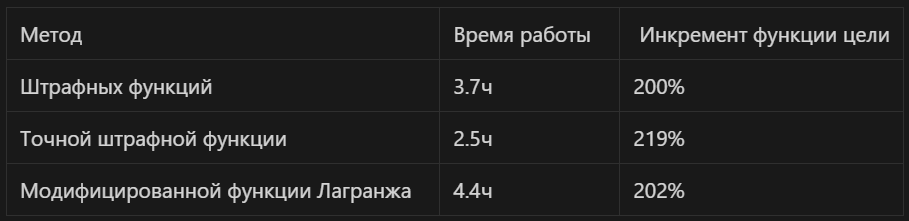

По результатам экспериментов мы пришли к следующим выводам:

- Метод штрафных функций и метод точной штрафной ф-ии проще в реализации и не требуют подбора и настройки большого кол-ва параметров. В наших тестах они показали себя лучше с точки зрения скорости и качества найденного решения

- Метод мод. ф-ии Лагранжа более требователен к подбору параметров, использует более сложные критерии останова, теоретически должен сходиться более плавно, без риска взрыва градиентов из-за большого стартового коэффициента штрафа